In [1]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.patches as patches
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dense, Flatten, Reshape
from keras.layers.convolutional import Conv2D, Conv3D
from keras.layers import MaxPooling2D
from keras.utils import plot_model
import graphviz
from keras.utils.vis_utils import pydot
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import theano
from keras import backend as K
import tensorflow
from theano import tensor
from matplotlib.pyplot import imshow
from keras.utils import np_utils
from keras.optimizers import SGD
from sklearn.preprocessing import normalize
from keras.layers import Dropout

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
IMAGE_SIZE = 72

In [3]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

In [4]:
def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

In [5]:
def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

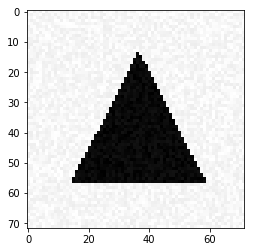

In [6]:
def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


In [7]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [8]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [9]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [10]:
def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

In [11]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

In [65]:
## 3 Simple Classificatiom

In [13]:
# Generating the data
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [14]:
#Converts Y to binary class matrix
np_utils.to_categorical(Y_train,3)


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0

In [15]:
# Creating a sequential model with one dense layer
model = Sequential()
model.add(Dense(3, activation='softmax', input_shape=(5184,)))


In [16]:
#optimize the mode with the gradient descent as optimizer
sgd = SGD(lr=0.01,decay=1e-6, momentum=0.9,nesterov=True)
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
#fit the model and check for it accuracy
model.fit(X_train,Y_train, batch_size=32,epochs=10)

Epoch 1/10
300/300 [==============================] - 1s 2ms/step - loss: 7.3374 - acc: 0.3633
Epoch 2/10
300/300 [==============================] - 0s 59us/step - loss: 8.8244 - acc: 0.3300
Epoch 3/10
300/300 [==============================] - 0s 76us/step - loss: 7.9691 - acc: 0.3367
Epoch 4/10
300/300 [==============================] - 0s 125us/step - loss: 8.6237 - acc: 0.3500
Epoch 5/10
300/300 [==============================] - 0s 67us/step - loss: 8.9998 - acc: 0.3633
Epoch 6/10
300/300 [==============================] - 0s 98us/step - loss: 7.4549 - acc: 0.3933
Epoch 7/10
300/300 [==============================] - 0s 69us/step - loss: 7.9586 - acc: 0.3900
Epoch 8/10
300/300 [==============================] - 0s 59us/step - loss: 7.8389 - acc: 0.3500
Epoch 9/10
300/300 [==============================] - 0s 73us/step - loss: 7.2797 - acc: 0.3733
Epoch 10/10
300/300 [==============================] - 0s 82us/step - loss: 6.9201 - acc: 0.4467


In [18]:
#Using the model to predict X_test(new data)
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
Y_predicted=model.predict(X_test)
Y_predicted


array([[1., 0., 0.]], dtype=float32)

In [19]:
#Get the weights
w=model.get_weights()[0]
w1=w[:,0]
w2=w[:,1]
w3=w[:,2]

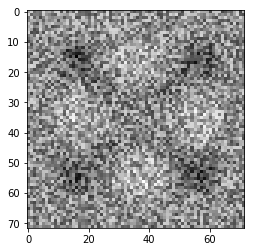

In [20]:
#Vizualising first column of the weights
plt.imshow(w1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

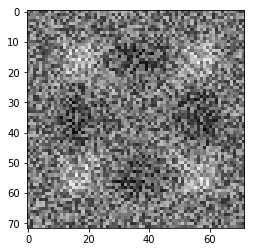

In [21]:
#Vizualising second column of the weights
plt.imshow(w2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

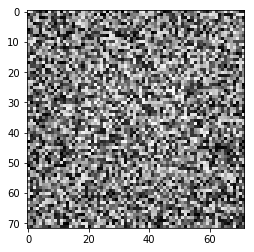

In [22]:
#Vizualising third column of the weights
plt.imshow(w3.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show

In [23]:
#optimizing the model with adam optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
#fit the model and check for it accuracy. Notice that the accuracy is slighly lower than gradient desent
model.fit(X_train,Y_train, batch_size=32,epochs=3)

Epoch 1/3
300/300 [==============================] - 0s 570us/step - loss: 6.5552 - acc: 0.4733
Epoch 2/3
300/300 [==============================] - 0s 171us/step - loss: 5.9137 - acc: 0.5167
Epoch 3/3
300/300 [==============================] - 0s 109us/step - loss: 5.8063 - acc: 0.6167


In [25]:
#Using the model to predic X_test
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
Y_predicted=model.predict(X_test)
Y_predicted

array([[0., 1., 0.]], dtype=float32)

In [26]:
#Getting the weights
w=model.get_weights()[0]
w1=w[:,0]
w2=w[:,1]
w3=w[:,2]

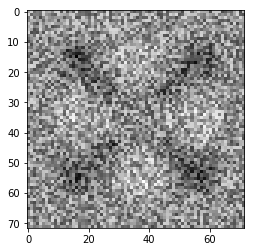

In [27]:
#Plotting the first second and third column of weights
plt.imshow(w1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


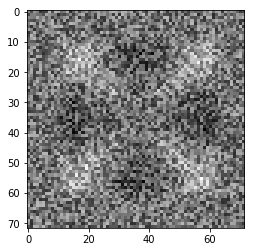

In [28]:
plt.imshow(w2.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


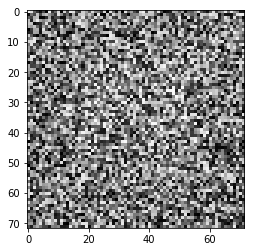

In [29]:
plt.imshow(w3.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [30]:
#Check for the loss and accuracy
#val_loss,val_accuracy = model.evaluate(X_test, Y_test)
#print(val_loss,val_accuracy)

In [31]:
#5 A More Difficult Classification Problem

In [32]:
#Generating the data set
[X_train, Y_train] = generate_dataset_classification(300, 20,True)
X_train.shape

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


(300, 5184)

In [33]:
#We need to change the shape of X_train and convert Y to a binary matrix
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)
Y_train=np_utils.to_categorical(Y_train)


In [34]:
# Creatin the sequential model with one convolution layer on maxpooling layer then we flatten the model and get our 
# our output with the dense layer
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu',input_shape=(72,72,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

In [35]:
#optimizin out model using adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
#fit the model and check for it accuracy
model.fit(X_train,Y_train, batch_size=32,epochs=10)
model.summary()

Epoch 1/10
300/300 [==============================] - 1s 4ms/step - loss: 1.3426 - acc: 0.3600
Epoch 2/10
300/300 [==============================] - 1s 3ms/step - loss: 0.9752 - acc: 0.5300
Epoch 3/10
300/300 [==============================] - 1s 4ms/step - loss: 0.7640 - acc: 0.7533
Epoch 4/10
300/300 [==============================] - 1s 4ms/step - loss: 0.7101 - acc: 0.7500
Epoch 5/10
300/300 [==============================] - 1s 3ms/step - loss: 0.6338 - acc: 0.7900
Epoch 6/10
300/300 [==============================] - 1s 3ms/step - loss: 0.6130 - acc: 0.7667
Epoch 7/10
300/300 [==============================] - 1s 3ms/step - loss: 0.5582 - acc: 0.8400
Epoch 8/10
300/300 [==============================] - 1s 2ms/step - loss: 0.5300 - acc: 0.8167
Epoch 9/10
300/300 [==============================] - 1s 3ms/step - loss: 0.4665 - acc: 0.8733
Epoch 10/10
300/300 [==============================] - 1s 3ms/step - loss: 0.4512 - acc: 0.8700
_________________________________________________

In [37]:
#generate test data set
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [38]:
# Evaluating our model
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE,1)
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 2ms/step


[0.729171002705892, 0.6566666662693024]

In [39]:
#6 A Regression Problem

In [142]:
#Generating the data set
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [143]:
#Building and training a regressor
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


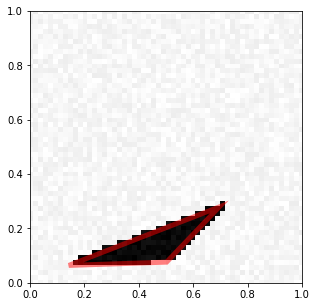

In [144]:
#visualizing training sample
visualize_prediction(X_train[0], Y_train[0])

In [145]:
X_Train = X_train.reshape([-1, 72,72,1])

In [193]:
# Creating the model
model=Sequential()
model.add(Conv2D(8, (3, 3))) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3))) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3))) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) 
model.add(Dense(6, ))

In [194]:
#optimizing
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [195]:
model.fit(X_Train,Y_train, batch_size=32,epochs=20)

Epoch 1/20
300/300 [==============================] - 2s 5ms/step - loss: 0.1694 - mean_absolute_error: 0.3260
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 0.0915 - mean_absolute_error: 0.2555
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 0.0829 - mean_absolute_error: 0.2438
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 0.0812 - mean_absolute_error: 0.2380
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 0.0687 - mean_absolute_error: 0.2192
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 0.0690 - mean_absolute_error: 0.2160
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 0.0592 - mean_absolute_error: 0.2030
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 0.0674 - mean_absolute_error: 0.2134
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 0.0599 - mean_absolute_error: 0.2041
E

In [196]:
X_Test = X_test.reshape([-1, 72,72,1])
Y_pred=model.predict(X_Test)


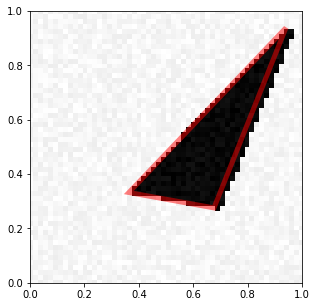

In [197]:
# visualizing the real y_test
visualize_prediction(X_Test[0], Y_test[0])

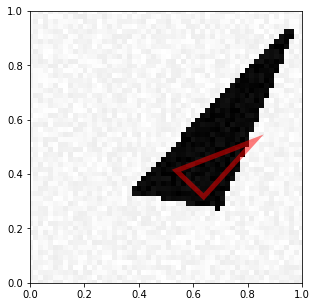

In [198]:
# Visualizing the predictedresult
visualize_prediction(X_Test[0], Y_pred[0])

In [111]:
# 7 Image Denoising

In [51]:
def generate_a_drawing_noise(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noise = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata_noise, imdata

def generate_a_rectangle_noise(free_location=False):
    noise = np.random.randint(0,100) #generate noise value randomly
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_noise(figsize, U, V, noise)

def generate_a_disk_noise(free_location=False):
    noise = np.random.randint(0,100)  #generate noise value randomly
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing_noise(figsize, U, V, noise)
  
def generate_a_triangle_noise(free_location=False):
    noise = np.random.randint(0,100) #generate noise value randomly
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing_noise(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_noise(nb_samples, free_location=False):
    # Getting im_size:
    noise = np.random.randint(0,100)  #generate noise value randomly
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,2,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle_noise(free_location)
        elif category == 1: 
            X[i] = generate_a_disk_noise(free_location)
        else:
            [X[i], V] = generate_a_triangle_noise(free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


In [52]:
#generate train set
training_data_set, cat = generate_dataset_noise(1000)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [53]:
#prepare training set and reshape
X_train = training_data_set[:,0]
Y_train = training_data_set[:,1]

X_train = X_train.reshape(1000,IMAGE_SIZE,IMAGE_SIZE,1)
Y_train = Y_train.reshape(1000,IMAGE_SIZE,IMAGE_SIZE,1)

In [54]:
#model
from keras.models import Input, Model
from keras.layers import UpSampling2D, Conv2D, MaxPooling2D

inp = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))


x=Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
model_denoiser = Model(inp, output)
model_denoiser.compile(optimizer="adam", loss='binary_crossentropy')
model_denoiser.fit(X_train, Y_train, epochs=10, batch_size=128,validation_split=0.2, shuffle=True, verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 15s 18ms/step - loss: 0.6427 - val_loss: 0.6185
Epoch 2/10
800/800 [==============================] - 14s 17ms/step - loss: 0.6170 - val_loss: 0.6066
Epoch 3/10
800/800 [==============================] - 15s 19ms/step - loss: 0.6024 - val_loss: 0.5913
Epoch 4/10
800/800 [==============================] - 14s 17ms/step - loss: 0.5839 - val_loss: 0.5719
Epoch 5/10
800/800 [==============================] - 13s 16ms/step - loss: 0.5659 - val_loss: 0.5551
Epoch 6/10
800/800 [==============================] - 12s 15ms/step - loss: 0.5481 - val_loss: 0.5389
Epoch 7/10
800/800 [==============================] - 14s 17ms/step - loss: 0.5388 - val_loss: 0.5340
Epoch 8/10
800/800 [==============================] - 12s 15ms/step - loss: 0.5350 - val_loss: 0.5329
Epoch 9/10
800/800 [==============================] - 14s 18ms/step - loss: 0.5333 - val_loss: 0.5326
Epoch 10/10
800/800 [===============

In [55]:
#generatinf the testing data set
test_data_set, _ = generate_dataset_noise(10, 20)

Creating data:
0


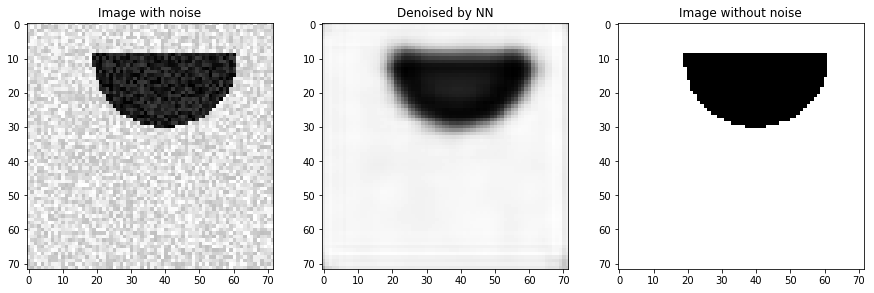

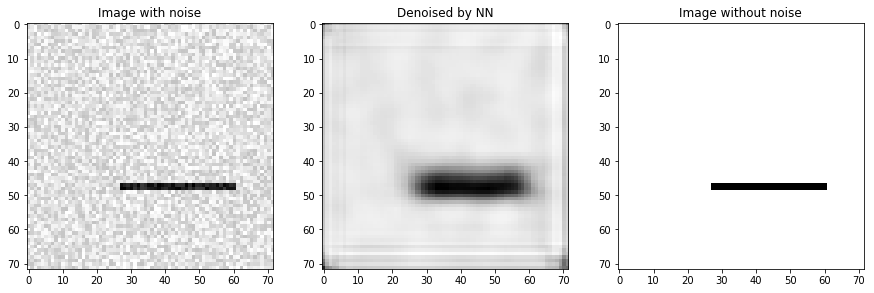

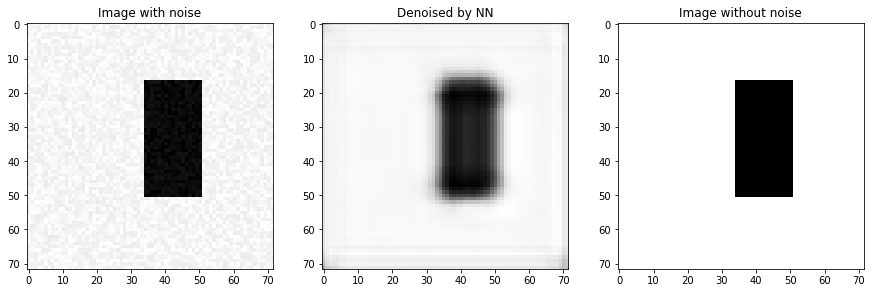

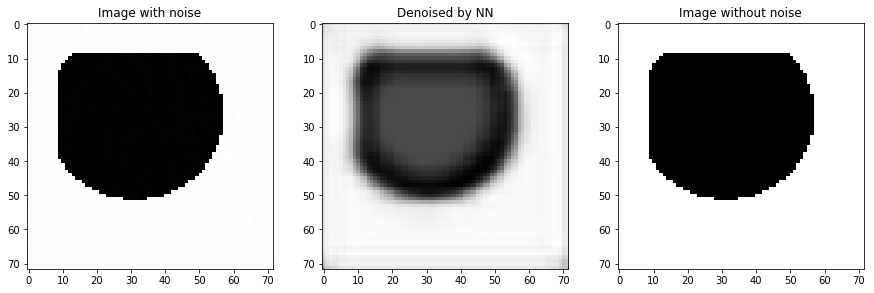

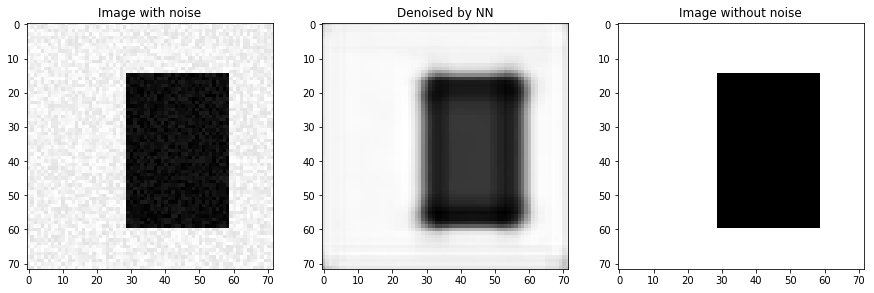

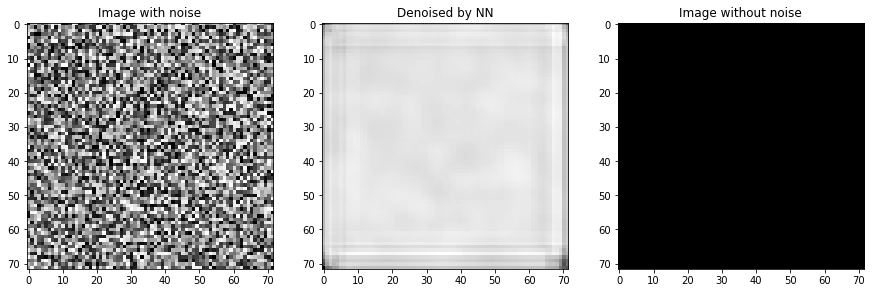

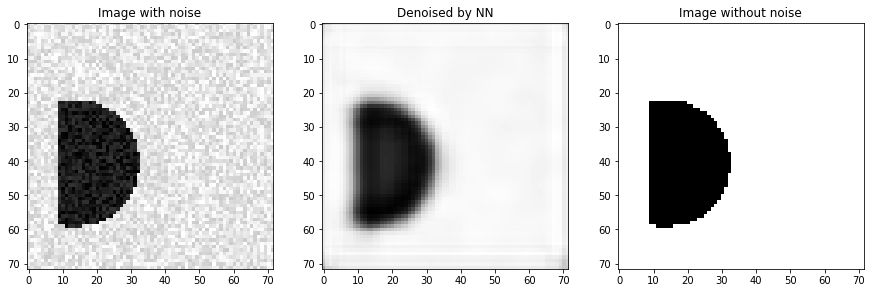

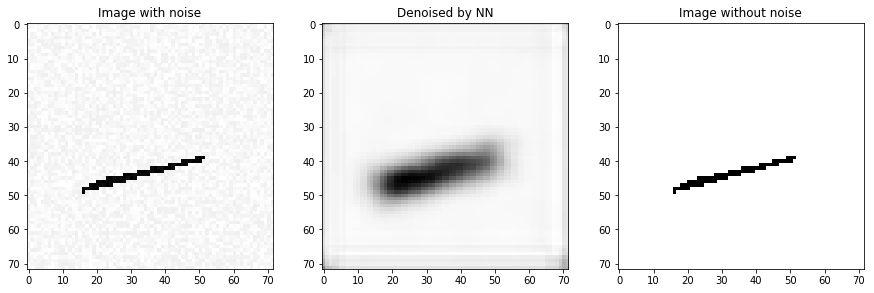

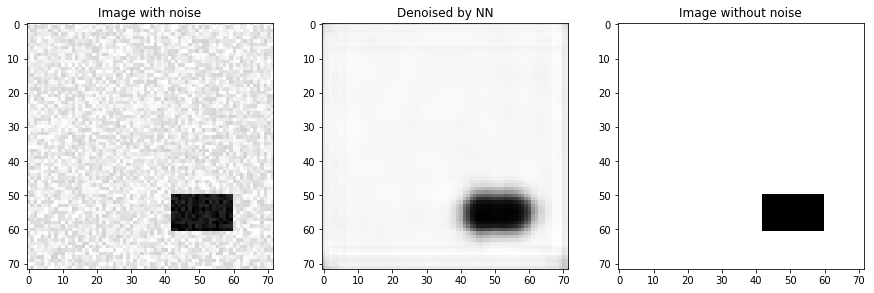

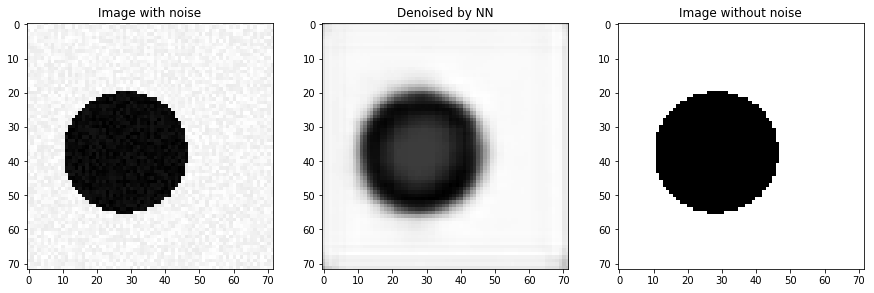

In [56]:
#preparing the testing data set and reshape
X_test = test_data_set[:,0]
Y_test = test_data_set[:,1]
X_test = X_test.reshape(10,IMAGE_SIZE,IMAGE_SIZE,1)
Y_test = Y_test.reshape(10,IMAGE_SIZE,IMAGE_SIZE,1)
for j in range(10):
  fig = plt.figure(figsize = (15,30))
  fig.tight_layout()
    
  ax = plt.subplot(1, 3, 1)
  plt.imshow(X_test[j].reshape((IMAGE_SIZE,IMAGE_SIZE)),cmap='gray')
  plt.title("Image with noise")

  ax = plt.subplot(1, 3, 2)
  plt.imshow((model_denoiser.predict(X_test[j].reshape((1,IMAGE_SIZE,IMAGE_SIZE,1)))).reshape((IMAGE_SIZE,IMAGE_SIZE)),cmap='gray')
  plt.title("Denoised by NN")

  ax = plt.subplot(1, 3, 3)
  plt.imshow(Y_test[j].reshape((IMAGE_SIZE,IMAGE_SIZE)),cmap='gray')
  plt.title("Image without noise")